In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words = open('names.txt', 'r').read().splitlines() # read the file and split by lines
chars = sorted(list(set(''.join(words)))) # get unique characters
vocab_size = len(chars) # size of the vocabulary
print('vocab_size:', vocab_size)

vocab_size: 26


In [4]:
stoi = {s: i+1 for i, s in enumerate(chars)} # character to index mapping
stoi['.'] = 0 # add a special token for padding
itos = {i: s for s, i in stoi.items()} # index to character mapping
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [78]:
#build the dataset
block_size = 3 # number of characters in each input block
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size # initialize context with padding token
    for ch in w + '.': # add a special token at the end
        ix = stoi[ch] # get the index of the character
        X.append(context) # append the current context
        Y.append(ix) # append the index of the character
        #print(''.join(itos[i] for i in context), '->', itos[ix]) # print the context and the character
        context = context[1:] + [ix] # update the context by removing the first character and adding the new one
X = torch.tensor(X) # convert to tensor
Y = torch.tensor(Y) # convert to tensor



In [79]:
X.shape, Y.shape # check the shapes of the input and output tensors

(torch.Size([228146, 3]), torch.Size([228146]))

In [12]:
C = torch.randn((vocab_size + 1, 2)) # character embedding matrix, +1 for padding token, 2 is the embedding dimension

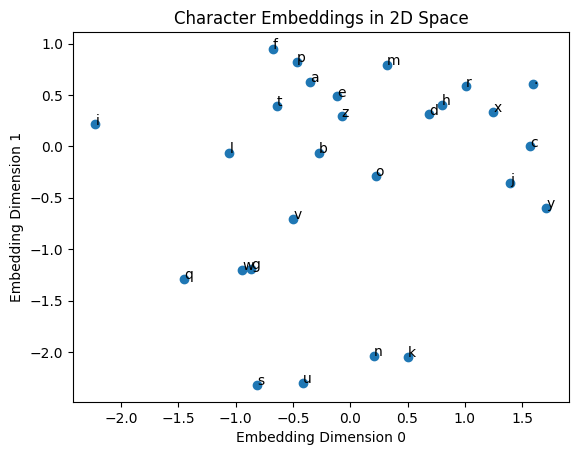

In [ ]:
import matplotlib.pyplot as plt

x_coords = [C[i, 0].item() for i in range(C.shape[0])]
y_coords = [C[i, 1].item() for i in range(C.shape[0])]

plt.scatter(x_coords, y_coords)
for i, char in enumerate('abcdefghijklmnopqrstuvwxyz.'):
    plt.annotate(char, (x_coords[i], y_coords[i]))
plt.xlabel('Embedding Dimension 0')  
plt.ylabel('Embedding Dimension 1')
plt.title('Character Embeddings in 2D Space')
plt.show()

In [34]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [ ]:
X[2,2] # integer index of the character at position (2,2)

tensor(13)

In [ ]:
C[X[2,2]] # get the embedding for the character at index X[2,2] 

tensor([ 0.2034, -2.0374])

In [40]:
C[13] # get the embedding for the character at index 13 
print(f"Character at index 13: '{itos[13]}'")  
print(f"C[13] = {C[13]}")  # The 2D embedding vector for 'm'

Character at index 13: 'm'
C[13] = tensor([ 0.2034, -2.0374])


In [ ]:
emb = C[X] # get the embeddings for all characters in X
emb.shape # check the shape of the embeddings tensor
torch.cat(torch.unbind(emb, dim=1), 1).shape # concatenate the embeddings along the last dimension 
# concatenation is not effiecient , because it creates a new tensor and requires additional memory allocation


torch.Size([32, 6])

In [54]:
emb.view(32,6) == torch.cat(torch.unbind(emb, dim=1), 1) # check if the reshaped embeddings match the concatenated embeddings

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [ ]:
W1 = torch.randn((2 * block_size, 100)) # first layer weights, 2*block_size input features, 100 output features
b1 = torch.randn(100) # first layer bias

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # compute the first layer output # -1 for batch size, -1 for automatic inference of the batch size
h.shape # check the shape of the first hidden layer 

torch.Size([32, 100])

In [57]:
# create final layer weights and bias
W2 = torch.randn((100, vocab_size + 1)) # second layer weights,
b2 = torch.randn(vocab_size + 1) # second layer bias

In [58]:
logits = h @ W2 + b2 # compute the logits for the final layer
logits.shape # check the shape of the logits tensor

torch.Size([32, 27])

In [ ]:
counts = logits.exp() # convert logits to fake counts
probs = counts / counts.sum(dim=1, keepdim=True) # convert counts to probabilities
probs.shape # check the shape of the probabilities tensor

torch.Size([32, 27])

In [62]:
probs[0].sum() # nor

tensor(1.0000)

In [63]:
Y.shape

torch.Size([32])

In [64]:
probs[torch.arange(32), Y] # get the probabilities for the true labels in Y

tensor([9.8688e-01, 4.5022e-07, 7.0517e-01, 7.0540e-06, 1.9143e-09, 1.3955e-05,
        8.7589e-10, 2.2391e-03, 9.8890e-01, 1.0183e-13, 5.0414e-05, 1.8582e-08,
        1.0167e-04, 2.3302e-06, 1.8671e-05, 1.1987e-01, 8.4176e-04, 3.8982e-09,
        1.4648e-04, 8.1503e-07, 4.1117e-07, 1.2955e-06, 2.0412e-06, 2.3084e-07,
        8.8921e-04, 2.0802e-07, 5.3798e-07, 1.2947e-03, 4.4937e-11, 2.4237e-01,
        1.4645e-05, 1.1500e-07])

In [65]:
loss = - probs[torch.arange(32), Y].log().mean() # compute the loss for each example
loss # print the loss value

tensor(11.8634)

In [66]:
# ---------------- Make it more readable ----------------

In [108]:
X.shape, Y.shape, # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [109]:
#for reproducibility
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [110]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481


- Embeddings (C): 54 parameters (1.5% of total)
- Hidden layer (W1 + b1): 700 parameters (20.1% of total)
- Output layer (W2 + b2): 2,727 parameters (78.4% of total)
#### => the output layer has the computation dominant!

In [89]:
#forward pass

emb = C[X] # get the embeddings for all characters in X
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # compute the first layer output
logits = h @ W2 + b2 # compute the logits for the final layer
#counts = logits.exp() # convert logits to fake counts
#probs = counts / counts.sum(dim=1, keepdim=True) # convert counts to probabilities
#loss = - probs[torch.arange(32), Y].log().mean() # compute the loss for each example
#loss # print the loss value

In [90]:
F.cross_entropy(logits, Y) # compute the loss using PyTorch's built-in function
# this function combines the softmax and the negative log likelihood loss in one step, which is more efficient and numerically stable
# ALSO: Pytorch does not create all the intermediate tensors like counts and probs, which saves memory and computation time,
# 
# ALSO : backward pass will be done automatically by PyTorch's autograd engine
# AlSO: this function is more numerically stable than the manual implementation, because it uses log-sum-exp trick to avoid overflow/underflow issues
# ALSO: it handles the case when the logits are very large or very small, which can lead to numerical instability in the softmax function
# ALSO: it can handle the case when the logits are not normalized, which can lead to incorrect probabilities
# ALSO: it can handle the case when the logits are not in the range [0, 1], which can lead to incorrect probabilities

tensor(2.7328, grad_fn=<NllLossBackward0>)

In [111]:
# training loop
for p in parameters:
    p.requires_grad = True # set requires_grad to True for all parameters


### Going through all the dataset: 
- for efficiency we use minibatches
- finding a good initial learning rate

In [112]:
lre = torch.linspace(-3, 0, 1000) # learning rate range
lrs = 10 ** lre # learning rates

In [120]:
lri = []
lossi = []
for i in range(1000): # training loop for 1000 iterations

    #minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # randomly sample 32 indices from the dataset
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # compute the first layer output
    logits = h @ W2 + b2 # compute the logits for the final layer
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute the gradients

    #update parameters
    lr = lrs[i] # get the learning rate based on the loss value
    for p in parameters:
        p.data -= lr * p.grad

#tracking stats
    lri.append(lre[i]) # append the learning rate to the list
    lossi.append(loss.item()) # append the loss value to the list
    
#print(loss.item()) # print the final loss value after training

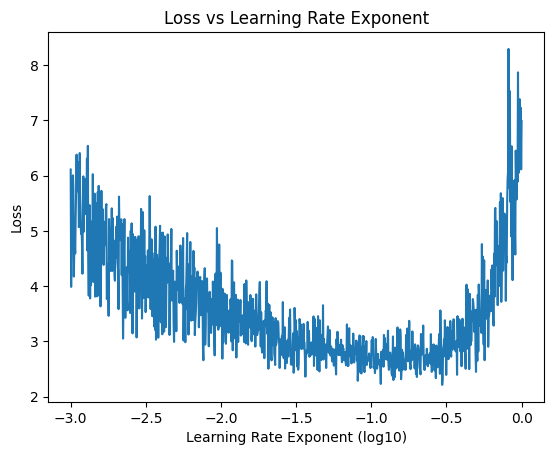

In [121]:
# Convert to Python lists if needed
lri_list = [exp.item() for exp in lri]  # exponents
lossi_list = lossi  # loss values (already Python floats from .item())

plt.plot(lri_list, lossi_list)
plt.xlabel('Learning Rate Exponent (log10)')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate Exponent')
plt.show()

In [122]:
# train / dev / test split

# build the dataset

def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)     #shuffle words in a reproducible way
random.shuffle(words)
n1 = int(0.8*len(words))    #80% for training
n2 = int(0.9*len(words))    #90% for training and dev

Xtr, Ytr = build_dataset(words[:n1]) # training set up to n1
Xdev, Ydev = build_dataset(words[n1:n2]) # dev set from n1 to n2
Xte, Yte = build_dataset(words[n2:])    # test set from n2 to the end

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [123]:
Xtr.shape, Ytr.shape, # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [147]:
#for reproducibility
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [173]:

sum(p.nelement() for p in parameters) # number of parameters in total
for p in parameters:
    p.requires_grad = True # set requires_grad to True for all parameters

In [159]:
lri = []
lossi = []
stepi = []

for i in range(30000): # training loop for 1000 iterations

    #minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,)) # randomly sample 32 indices from the dataset
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # compute the first layer output
    logits = h @ W2 + b2 # compute the logits for the final layer
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute the gradients

    #update parameters
    #lr = lrs[i] # get the learning rate based on the loss value
    lr = 0.01 # fixed learning selected from graph above
    for p in parameters:
        p.data -= lr * p.grad

#tracking stats
    stepi.append(i) # append the iteration number to the list
    #lri.append(lre[i]) # append the learning rate to the list
    lossi.append(loss.item()) # append the loss value to the list
    

print(loss.item()) # print the final loss value after training

2.52970027923584


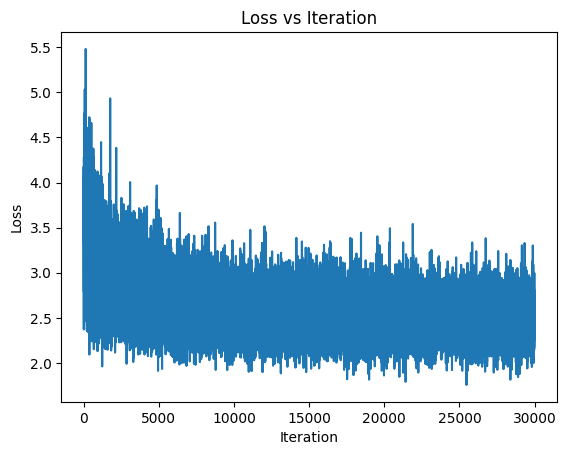

In [151]:
plt.plot(stepi, lossi)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

In [158]:
# evaluate on development set

emb = C[Xdev] # get the embeddings for all characters in Xtr 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # compute the first layer output
logits = h @ W2 + b2 # compute the logits for the final layer
loss = F.cross_entropy(logits, Ydev) # compute the loss for the training set
loss


tensor(2.3414, grad_fn=<NllLossBackward0>)

The relationship between training and development loss reveals the model's state. When both losses are similar but high, your model is being "honest" - it performs equally on seen and unseen data, indicating it's not overfitting but rather lacks sufficient capacity to capture the underlying patterns (underfitting). This suggests increasing model complexity through more parameters, larger embeddings, or additional layers. So we increase the Neurons of the hidden layer from 100 to 300 and repeat the training process

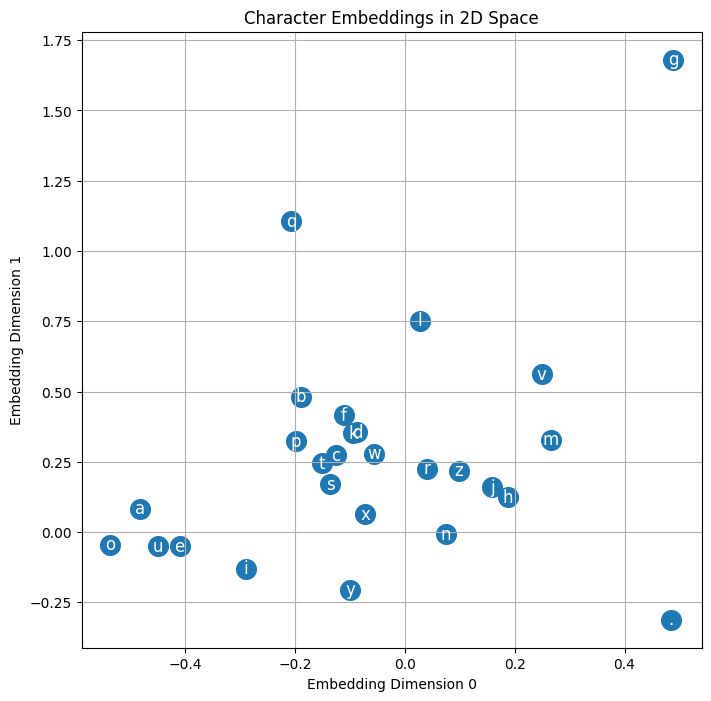

In [162]:
plt.figure(figsize=(8,8))

# Extract coordinates using .item()
x_coords = [C[i, 0].item() for i in range(C.shape[0])]
y_coords = [C[i, 1].item() for i in range(C.shape[0])]

plt.scatter(x_coords, y_coords, s=200)
for i in range(C.shape[0]):
    plt.text(x_coords[i], y_coords[i], itos[i], ha='center', va='center', color='white', fontsize=12)
plt.xlabel('Embedding Dimension 0')
plt.ylabel('Embedding Dimension 1')
plt.title('Character Embeddings in 2D Space')
plt.grid(True)  # 'minor' should be True
plt.show()

In [ ]:
# some clustering of characters in the embedding space (vowels, consonants,)
# bottleneck of network maybe the 2d embedding space is too small to capture the complexity of the data

In [170]:
# incerase embeddding space to 10 dimensions
#for reproducibility
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) # also decrease the neurons from 300 to 200
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [171]:
lri = []
lossi = []
stepi = []

In [174]:

for i in range(200000): # training loop for 1000 iterations

    #minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,)) # randomly sample 32 indices from the dataset
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # compute the first layer output
    logits = h @ W2 + b2 # compute the logits for the final layer
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute the gradients

    #update parameters
    #lr = lrs[i] # get the learning rate based on the loss value
    lr = 0.1 if i < 100000 else 0.01 # fixed learning selected from graph above
    for p in parameters:
        p.data -= lr * p.grad

#tracking stats
    stepi.append(i) # append the iteration number to the list
    #lri.append(lre[i]) # append the learning rate to the list
    lossi.append(loss.log10().item()) # append the loss value to the list
    

In [175]:
emb = C[Xtr] # get the embeddings for all characters in Xtr 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # compute the first layer output
logits = h @ W2 + b2 # compute the logits for the final layer
loss = F.cross_entropy(logits, Ytr) # compute the loss for the training set
loss

tensor(2.1386, grad_fn=<NllLossBackward0>)

In [176]:
emb = C[Xdev] # get the embeddings for all characters in Xdev
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # compute the first layer output
logits = h @ W2 + b2 # compute the logits for the final layer
loss = F.cross_entropy(logits, Ydev) # compute the loss for the dev set
loss

tensor(2.1776, grad_fn=<NllLossBackward0>)

In [179]:
# sample the model
g = torch.Generator().manual_seed(2147483647) # for reproducibility
for _ in range(10): # generate 10 names
    out = []
    context = [0] * block_size # start with the padding token
    while True: # generate characters until we hit the padding token
        emb = C[torch.tensor(context)] # get the embeddings for the current context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # compute the first layer output
        logits = h @ W2 + b2 # compute the logits for the final layer
        probs = F.softmax(logits, dim=1) # convert logits to probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix == 0: # if we hit the padding token (end of name) then stop generating
            break
        out.append(itos[ix]) #Convert index to character and add to output
        context = context[1:] + [ix] # update the context by removing the first character and adding the new one
    print(''.join(out)) # syntax: separator.join(list_of_strings)

# model learns the statistical pattern about character sequences in names

junide
jakarie
parlay
aire
kaiistto
sani
ter
kalania
zamilena
jadeyaine
